In [258]:
import pandas as pd
import matplotlib as mpl
import numpy as np

import os
import sklearn
from sklearn import preprocessing, linear_model, model_selection
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [259]:
def read_csv(file_name):
    return pd.read_csv(file_name)

# Data Cleaning

## Yad2.co.il Data
Inorder to acquire larger amount of data, we used 2 data source. In this section we will only handle the Yad2.co.il data, which we scrapped using our selenium crawler.
We will first load the CSV file into a Data Frame and take a quick look at it.

In [260]:
yad2_df = read_csv('raw_yad2_data.csv')
yad2_df.head()

,Post link,City,Neighborhood,Size,Number of rooms,Floor number,Taxes,Price,Room mates,Furniture,Elevator,Air conditioner,Parking,Balcony,Bars,Shelter,Storeroom,Renovated,Boiler,Pets allowed
0,dks8vn48,חדרה,גבעת אולגה,127,4.0,5.0,980.0,4700.0,1,1,1,1,1,1.0,1,1,1,1,1,1
1,jmjfaz37,חיפה,"יל""ג",65,3.5,1.0,NaN,2400.0,1,1,1,1,0,NaN,1,1,1,1,1,1
2,iphkc13r,רמות ספיר,"שכונה י""א",70,3.0,1.0,400.0,2450.0,1,1,1,1,1,NaN,1,1,1,1,1,1
3,9chmff31,קרית אתא,מרכז העיר,70,3.0,1.0,500.0,2900.0,1,1,1,1,0,NaN,1,1,1,1,1,1
4,yp7la93q,מגדל העמק,רמת בלפור,80,3.5,3.0,512.0,2095.0,1,1,1,1,1,NaN,1,1,1,1,1,1


In [261]:
yad2_df.shape

(9110, 20)

#### Removing duplicates
We used the 'Post link' feature as a unique identifier for each entry. The 'Post link' is the suffix of the URL which is used to identify each post. For example, a link to a post will look like: "https://www.yad2.co.il/item/x29qkv38", so it's 'Post link' will be "x29qkv38".
We can see that we had about 3000 duplicates, this is because the crawler sometimes would fail, or get blocked by the server, so it will try to get the whole page again and this would create many duplicates.

In [262]:
yad2_df.drop_duplicates(['Post link'], inplace=True)
yad2_df.shape

(6650, 20)

#### Handling null values
The 'Price' and 'Number of rooms' are 2 key features in our data set. Because of that, we decided to drop entries that had that value missing.
As we can see, we will only lose about 200 entries, which is not much.

In [263]:
yad2_df.dropna(subset=['Price', 'Number of rooms'], inplace=True)
yad2_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6344 entries, 0 to 9109
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Post link        6344 non-null   object 
 1   City             6344 non-null   object 
 2   Neighborhood     6344 non-null   object 
 3   Size             6344 non-null   int64  
 4   Number of rooms  6344 non-null   float64
 5   Floor number     5960 non-null   float64
 6   Taxes            2866 non-null   float64
 7   Price            6344 non-null   float64
 8   Room mates       6344 non-null   int64  
 9   Furniture        6344 non-null   int64  
 10  Elevator         6344 non-null   int64  
 11  Air conditioner  6344 non-null   int64  
 12  Parking          6344 non-null   int64  
 13  Balcony          2871 non-null   float64
 14  Bars             6344 non-null   int64  
 15  Shelter          6344 non-null   int64  
 16  Storeroom        6344 non-null   int64  
 17  Renovated     

We chose to fill in the missing values in some features.
The missing values of the 'Balcony' feature is due to fact that some posts were missing that value, so we took an assumption that if an apartment would have a balcony, the owner would have mentioned it in the post, and if he didn't, that is probably because there is no balcony.

To fill the missing values of the 'Floor number' feature we chose to use median, because it gives less weigh to edge values. Meaning that if we had an entry with 'Floor number' of 100, it wouldn't affect as much on the median as it would affect the average.

In [264]:
yad2_df['Floor number'].fillna(value=yad2_df['Floor number'].median(), inplace=True)
yad2_df['Balcony'].fillna(value=0, inplace=True)
yad2_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6344 entries, 0 to 9109
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Post link        6344 non-null   object 
 1   City             6344 non-null   object 
 2   Neighborhood     6344 non-null   object 
 3   Size             6344 non-null   int64  
 4   Number of rooms  6344 non-null   float64
 5   Floor number     6344 non-null   float64
 6   Taxes            2866 non-null   float64
 7   Price            6344 non-null   float64
 8   Room mates       6344 non-null   int64  
 9   Furniture        6344 non-null   int64  
 10  Elevator         6344 non-null   int64  
 11  Air conditioner  6344 non-null   int64  
 12  Parking          6344 non-null   int64  
 13  Balcony          6344 non-null   float64
 14  Bars             6344 non-null   int64  
 15  Shelter          6344 non-null   int64  
 16  Storeroom        6344 non-null   int64  
 17  Renovated     

#### Removing unnecessary features

In [265]:
yad2_df.drop(['Post link', 'Taxes'], axis=1, inplace=True)

## Homeless.co.il Data
We will follow the same procedure as before for the Homeless data set.
We loaded the CSV and took a look at a few entries.

In [266]:
homeless_df = read_csv('raw_homeless_data.csv')
homeless_df.head()

,Page number,City,Neighborhood,Size,Number of rooms,Floor number,Taxes,Price,Room mates,Furniture,Elevator,Air conditioner,Parking,Balcony,Bars,Shelter,Storeroom,Renovated,Boiler,Pets allowed
0,685019,חיפה,נוה שאנן,80.0,3.0,3.0,1150,3400.0,0,1,0,1,0,0,0,0,0,1,1,0
1,685018,חיפה,נווה שאנן,35.0,1.0,1.0,280,1950.0,0,1,0,1,0,0,1,0,0,1,1,0
2,685017,פוריה כפר עבודה,החרוב,90.0,3.0,0.0,0,3800.0,0,0,0,1,1,1,0,0,0,1,0,0
3,685016,פוריה כפר עבודה,החרוב,90.0,3.0,0.0,0,3800.0,0,0,0,1,1,1,0,0,0,1,0,0
4,685015,תל אביב יפו,גימל החדשה,86.0,3.0,1.0,1180,11000.0,0,1,1,1,1,1,0,1,0,1,0,1


In [267]:
homeless_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4522 entries, 0 to 4521
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Page number      4522 non-null   int64  
 1   City             4521 non-null   object 
 2   Neighborhood     4522 non-null   object 
 3   Size             4485 non-null   float64
 4   Number of rooms  4475 non-null   float64
 5   Floor number     4511 non-null   float64
 6   Taxes            4522 non-null   int64  
 7   Price            4475 non-null   float64
 8   Room mates       4522 non-null   int64  
 9   Furniture        4522 non-null   int64  
 10  Elevator         4522 non-null   int64  
 11  Air conditioner  4522 non-null   int64  
 12  Parking          4522 non-null   int64  
 13  Balcony          4522 non-null   int64  
 14  Bars             4522 non-null   int64  
 15  Shelter          4522 non-null   int64  
 16  Storeroom        4522 non-null   int64  
 17  Renovated     

In [268]:
homeless_df.describe(include='all')

,Page number,City,Neighborhood,Size,Number of rooms,Floor number,Taxes,Price,Room mates,Furniture,Elevator,Air conditioner,Parking,Balcony,Bars,Shelter,Storeroom,Renovated,Boiler,Pets allowed
count,4522.000000,4521,4522,4.485000e+03,4475.000000,4511.000000,4522.000000,4475.000000,4522.000000,4522.000000,4522.000000,4522.000000,4522.000000,4522.000000,4522.000000,4522.000000,4522.000000,4522.000000,4522.000000,4522.000000
unique,NaN,309,1366,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,תל אביב יפו,מרכז,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,535,249,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,680868.547103,NaN,NaN,2.772780e+06,8.690056,2.136777,529.189297,4429.810056,0.261389,0.543344,0.346970,0.943830,0.698806,0.474348,0.324856,0.115436,0.102609,0.276648,0.325962,0.126714
std,4014.757757,NaN,NaN,1.842839e+08,11.982899,1.878139,3472.852395,4280.285176,0.439440,0.498173,0.476059,0.230275,0.458828,0.499397,0.468373,0.319582,0.303482,0.447390,0.468785,0.332689
min,665030.000000,NaN,NaN,0.000000e+00,1.000000,-1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,680224.500000,NaN,NaN,6.000000e+01,3.000000,1.000000,0.000000,2900.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,681750.500000,NaN,NaN,7.500000e+01,3.000000,2.000000,200.000000,3800.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,683504.750000,NaN,NaN,9.900000e+01,5.000000,3.000000,620.000000,4950.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000


#### Removing duplicates
As before, we used the 'Page number' as a unique identifier for each entry. This feature holds the number of the post that is listed at Homeless. If we have a post with the following link: "https://www.homeless.co.il/rent/viewad,685021", it's post number would be "685021".
This time, we only had 1 duplicate to remove.

In [269]:
homeless_df.drop_duplicates(['Page number'], inplace=True)
homeless_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4521 entries, 0 to 4521
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Page number      4521 non-null   int64  
 1   City             4520 non-null   object 
 2   Neighborhood     4521 non-null   object 
 3   Size             4484 non-null   float64
 4   Number of rooms  4474 non-null   float64
 5   Floor number     4510 non-null   float64
 6   Taxes            4521 non-null   int64  
 7   Price            4474 non-null   float64
 8   Room mates       4521 non-null   int64  
 9   Furniture        4521 non-null   int64  
 10  Elevator         4521 non-null   int64  
 11  Air conditioner  4521 non-null   int64  
 12  Parking          4521 non-null   int64  
 13  Balcony          4521 non-null   int64  
 14  Bars             4521 non-null   int64  
 15  Shelter          4521 non-null   int64  
 16  Storeroom        4521 non-null   int64  
 17  Renovated     

#### Handling null values
We chose to drop entries that were missing critical features.
the amount of the data we lost was pretty small (150~) so it's not that bad.

In [270]:
homeless_df.dropna(subset=['Price', 'City', 'Number of rooms', 'Size'], inplace=True)
homeless_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4401 entries, 0 to 4521
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Page number      4401 non-null   int64  
 1   City             4401 non-null   object 
 2   Neighborhood     4401 non-null   object 
 3   Size             4401 non-null   float64
 4   Number of rooms  4401 non-null   float64
 5   Floor number     4392 non-null   float64
 6   Taxes            4401 non-null   int64  
 7   Price            4401 non-null   float64
 8   Room mates       4401 non-null   int64  
 9   Furniture        4401 non-null   int64  
 10  Elevator         4401 non-null   int64  
 11  Air conditioner  4401 non-null   int64  
 12  Parking          4401 non-null   int64  
 13  Balcony          4401 non-null   int64  
 14  Bars             4401 non-null   int64  
 15  Shelter          4401 non-null   int64  
 16  Storeroom        4401 non-null   int64  
 17  Renovated     

To handle the null values for the 'Floor number' feature, we used median. Same as we did for the Yad2 data set

In [271]:
homeless_df['Floor number'].fillna(value=homeless_df['Floor number'].median(), inplace=True)
homeless_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4401 entries, 0 to 4521
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Page number      4401 non-null   int64  
 1   City             4401 non-null   object 
 2   Neighborhood     4401 non-null   object 
 3   Size             4401 non-null   float64
 4   Number of rooms  4401 non-null   float64
 5   Floor number     4401 non-null   float64
 6   Taxes            4401 non-null   int64  
 7   Price            4401 non-null   float64
 8   Room mates       4401 non-null   int64  
 9   Furniture        4401 non-null   int64  
 10  Elevator         4401 non-null   int64  
 11  Air conditioner  4401 non-null   int64  
 12  Parking          4401 non-null   int64  
 13  Balcony          4401 non-null   int64  
 14  Bars             4401 non-null   int64  
 15  Shelter          4401 non-null   int64  
 16  Storeroom        4401 non-null   int64  
 17  Renovated     

#### Removing unnecessary features

In [272]:
homeless_df.drop(['Page number', 'Taxes'], axis=1, inplace=True)

# Concatenating the data frames
Now that we cleaned both the Yad2 and Homeless data frames, we can merge them and manipulate them as one data frame.
We can see that we got a total of around 10,000 entries and more than 160,000 pieces of data.

In [273]:
df = pd.concat([yad2_df, homeless_df], ignore_index=True, sort=False)
df.shape

(10745, 18)

#### Handle mis-matches in the 2 data sets
We noticed a few mismatches between the 2 data sets in string fields. For example, in Yad2 the value for Tel-Aviv could be "תל-אביב" and in Homeless it could be "תל אביב". We would like to map those 2 different values into 1. This issue had required alot of manual work.
Check the output below to see the issue with the 'City' feature.

In [274]:
df['City'].value_counts()

חיפה                 1057
תל אביב יפו           704
באר שבע               684
ירושלים               578
בת ים                 566
                     ... 
קריית באליק             1
אשקלון                  1
יוקינעם                 1
קרית יובל ירושלים       1
יפו                     1
Name: City, Length: 448, dtype: int64

In [275]:
df.loc[df['City'].isin(['Bat Yam', 'בת יים', 'נבת ים', 'בת ים','רמת יוסף','פארק הים','קוממיות']), 'City'] = 'בת ים'
df.loc[df['City'].isin(['ראשון', 'ראשוון לציון', 'ראשוןון לציון', 'ראשל"צ', 'ראשון לציון','ראשו','ראשון לציון מערב','מערב ותיק']), 'City'] = 'ראשון לציון'
df.loc[df['City'].isin(['פתח תקווה', 'פתח תקוה', 'G פתח תקווה','פתח תקווה','פתח ','פתח תקווהתקווה']), 'City'] = 'פתח תקווה'
df.loc[df['City'].isin(['נהריה', 'נהרייה','רסקו']), 'City'] = 'נהרייה'
df.loc[df['City'].isin(['תל-אביב', 'תל אביב יפו', 'תל אביב', 'תל אביב', '⁹תל אביב יפו', 'תל אביב טופ דן', 'תל א', 'שרונה', 'המושבה האמריקאית-גרמנית','פארק צמרת','נווה שרת','שיכוני חסכון','שכונת דן','שרונה','רמת אביב','רמת אביב ג','רמת אביב החדשה','צפון תל אביב הישן','כוכב הצפון','יפו ג','אזור המלאכה יפו','יפו ד.','גבעת העליה','גימל החדשה','נוה ברבור','הארגזים','גבעת התמרים','גבעת העליה']), 'City'] = 'תל אביב'
df.loc[df['City'].isin(['ירשלים', 'ירושלים טלביה', 'ירושלים', 'ירושליים','ירושלים פסגת זאב מזרח','קרית הממשלה','פיסגת זאב', 'פסגת זאב', 'פיסגתזאב','קרית יובל ירושלים','תלפיות מזרח','הגבעה הצרפתית',' בית יעקב','הר חומה']), 'City'] = 'ירושלים'
df.loc[df['City'].isin(['טירת הכרמל', 'טירת כרמ', 'טירת כרמלכרמל', 'טירת כרמל']), 'City'] = 'טירת כרמל'
df.loc[df['City'].isin(['רמת גן','ררמת גן','רמת גןנגבהמ','רמת גן ','G רמת גן','רמתגן','רמת יצחק',"מרכז העיר ג'",'מרכז העיר א','מרכז העיר ב','מרכז העיר']), 'City'] = 'רמת גן'
df.loc[df['City'].isin(['יוקינעם','יוקנעם','יקנעם עילית']), 'City'] = 'יקנעם'
df.loc[df['City'].isin(['גבעתיים','גבעתיים ']), 'City'] = 'גבעתיים'
df.loc[df['City'].isin(['אשקלון','אשקלון ','אשקלון.רמת האשכול']), 'City'] = 'אשקלון'
df.loc[df['City'].isin(['הדרים החדשה','כפר סבא','כפר סבא ']), 'City'] = 'כפר סבא'
df.loc[df['City'].isin(['רחובות','רחובות ']), 'City'] = 'רחובות'
df.loc[df['City'].isin(['חדרה','חדרה ','חדרה הצעירה','חטיבת הנחל חדרה']), 'City'] = 'חדרה'
df.loc[df['City'].isin(['אשדוד','אשדוד,איזור ב',]), 'City'] = 'אשדוד'
df.loc[df['City'].isin(['חריש','נחריש','קציר חריש']), 'City'] = 'חריש'
df.loc[df['City'].isin(['אלעד','אלעד ']), 'City'] = 'אלעד'
df.loc[df['City'].isin(['הרצליה','מרינה הרצליה ','הרצליה ','rרמת השרון /הרצליה']), 'City'] = 'הרצליה'
df.loc[df['City'].isin(['Bבאר שבע', 'באר שבע', 'באר ש']), 'City'] = 'באר שבע'
df.loc[df['City'].isin(['פרדס חנה',' פרדס חנה - כרכור ','פרדס חנה כרכור']), 'City'] = 'פרדס חנה'
df.loc[df['City'].isin(['כרמיאל','כרמיאל ']), 'City'] = 'כרמיאל'
df.loc[df['City'].isin(['ראש העין','פסגות אפק']), 'City'] = 'ראש העין'
df.loc[df['City'].isin(['קריית אתא','קרית אתא.','קרית את','קרית אתא','גבעת העליה']), 'City'] = 'קריית אתא'
df.loc[df['City'].isin(['קירית ביאליק','קריית באליק','קריית ביאליק']), 'City'] = 'קריית ביאליק'
df.loc[df['City'].isin(['חיפה','נאות פרס','חיפה הדר','חיפה אחוזה','jחיפה','רמב"ם','תחנת רכבת השמונה ','ואדי סאליב']), 'City'] = 'חיפה'
df.loc[df['City'].isin(['אילת','מערב 1','מערב 2']), 'City'] = 'אילת'
df.loc[df['City'].isin(['שוהם','ושוהם']), 'City'] = 'שוהם'
df.loc[df['City'].isin(['רמת אליהו','רמת הליאו']), 'City'] = 'רמת אליהו'
df.loc[df['City'].isin(['בני ברק','בני ברק גבול רמת גן']), 'City'] = 'בני ברק'
df.loc[df['City'].isin(['אור ים','אור עקיבא','אור עקיבא ']), 'City'] = 'אור עקיבא'
df.loc[df['City'].isin(['נוף הגליל','נצרת עילית','נצרת עילית / נוף הגליל']), 'City'] = 'נצרת עילית'
df.loc[df['City'].isin(['קרית מלאכי','אחוזת רוטנר']), 'City'] = 'קריית מלאכי'
df.loc[df['City'].isin(['טבריה',"שיכון ד'","שיכון ה'"," שיכון ג'"]), 'City'] = 'טבריה'


df['City'].value_counts()

חיפה       1083
תל אביב     787
באר שבע     686
ירושלים     624
בת ים       580
           ... 
רהט           1
גני טל        1
שקד           1
אלקנה         1
יפו           1
Name: City, Length: 339, dtype: int64

#### Removing cities with less than 10 occurrences

In [276]:
city_counts = df['City'].value_counts()
for city, count in city_counts.items():
    if int(count) < 10:
        df.drop(df[df.City == city].index, inplace=True)

df['City'].value_counts()

חיפה         1083
תל אביב       787
באר שבע       686
ירושלים       624
בת ים         580
             ... 
קרית חיים      11
עספיא          10
גדרה           10
בית דגן        10
שוהם           10
Name: City, Length: 94, dtype: int64

#### Handling out-liers


In [277]:
columns_list = ['Size', 'Price', 'Number of rooms']
for col in columns_list:
    q1 = np.percentile(df[col],25)
    q3 = np.percentile(df[col],75)
    iqr = q3-q1
    df = df[(df[col] > q1-1.5*iqr) & (df[col] < q3+1.5*iqr)]

df.shape

(8182, 18)

# Visualization

#### Amount of records per each city

<AxesSubplot:>

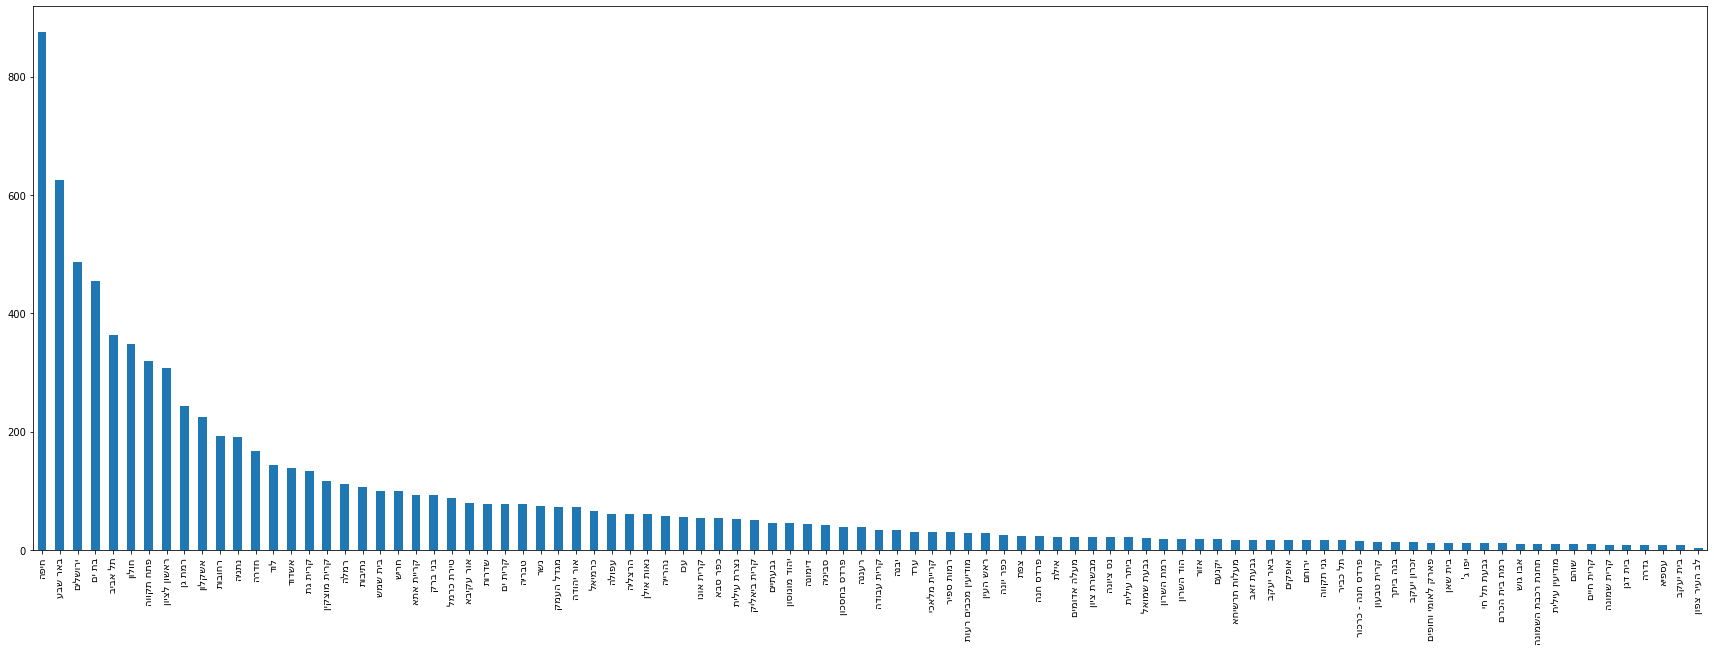

In [278]:
city_count = df['City'].value_counts()
reverse_cities_names = []
for name, value in city_count.items():
    reverse_cities_names.append(name[::-1])
flipped = pd.Series(city_count.values, index=reverse_cities_names)
flipped.plot(kind='bar', figsize=(30,10))

# Machine learning

#### Split label

In [279]:
y = df['Price']
X = df.drop(['Price'], axis=1)

In [280]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
print(X_train, X_test, y_train, y_test)

             City   Neighborhood   Size  Number of rooms  Floor number  \
0            חדרה     גבעת אולגה  127.0              4.0           5.0   
1            חיפה           יל"ג   65.0              3.5           1.0   
2       רמות ספיר      שכונה י"א   70.0              3.0           1.0   
3       קריית אתא      מרכז העיר   70.0              3.0           1.0   
4       מגדל העמק      רמת בלפור   80.0              3.5           3.0   
...           ...            ...    ...              ...           ...   
8069        בת ים          ניצנה   50.0              2.0           2.0   
8070         חיפה      נווה יוסף   65.0              3.0           4.0   
8072  ראשון לציון         רמב``ם   85.0              4.0           4.0   
8073        בת ים  שכונת קלאוזנר  100.0              3.0           3.0   
8074     כפר יונה         שרונה   145.0              4.0           1.0   

      Room mates  Furniture  Elevator  Air conditioner  Parking  Balcony  \
0              1          1        

#### Scailing

In [281]:
def scale_features(X_train, scale_type):
    if(scale_type == 'minmax'):
         scaler=MinMaxScaler(feature_range=(0, 1))
    else:
        scaler=StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    return scaler, X_train_scaled

In [282]:
X_train2 = X_train.drop(['City','Neighborhood'], axis=1)
minmax_scaler, X_train_minmax_scaled = scale_features(X_train2, 'minmax')
standard_scaler, X_train_standard_scaled = scale_features(X_train2, 'standard')
print(standard_scaler, X_train_standard_scaled)

StandardScaler() [[ 1.79804568  0.85810149  0.8054315  ...  0.29224357  0.2300607
   0.39257794]
 [-0.58692384  0.25820037 -0.74342972 ...  0.29224357  0.2300607
   0.39257794]
 [-0.39458759 -0.34170074 -0.74342972 ...  0.29224357  0.2300607
   0.39257794]
 ...
 [ 0.18242116  0.85810149  0.41821619 ...  0.29224357  0.2300607
   0.39257794]
 [ 0.75942992 -0.34170074  0.03100089 ...  0.29224357  0.2300607
  -2.54726488]
 [ 2.49045618  0.85810149 -0.74342972 ... -3.42180331  0.2300607
   0.39257794]]


#### Complete the Scailing

In [283]:
def scale_test_features(X_test, scaler):
    return scaler.transform(X_test)

In [284]:
X_test2 = X_test.drop(['City','Neighborhood'], axis=1)
X_test_minmax_scaled = scale_test_features(X_test2, minmax_scaler)
X_test_standard_scaled = scale_test_features(X_test2, standard_scaler)
print(X_test_standard_scaled)

[[-0.24071859 -0.34170074  0.03100089 ...  0.29224357  0.2300607
   0.39257794]
 [-1.35626885 -1.54150298 -1.13064502 ...  0.29224357 -4.34667885
  -2.54726488]
 [-1.35626885 -1.54150298 -1.13064502 ...  0.29224357 -4.34667885
  -2.54726488]
 ...
 [ 1.14410242  0.85810149 -0.35621441 ... -3.42180331 -4.34667885
  -2.54726488]
 [-1.35626885 -1.54150298 -1.13064502 ... -3.42180331 -4.34667885
  -2.54726488]
 [ 1.91344743  2.05790373 -1.13064502 ... -3.42180331 -4.34667885
  -2.54726488]]


In [285]:
print(np.any(np.isnan(X_train2)))
print(np.any(np.isfinite(X_train2)))

False
True


In [286]:
r = X_train2.index[np.isinf(X_train2).any(1)]
print(r)

Int64Index([], dtype='int64')


#### Train a classification model

In [287]:
X_train2.describe()

,Size,Number of rooms,Floor number,Room mates,Furniture,Elevator,Air conditioner,Parking,Balcony,Bars,Shelter,Storeroom,Renovated,Boiler,Pets allowed
count,6545.000000,6545.000000,6545.000000,6545.000000,6545.000000,6545.000000,6545.000000,6545.000000,6545.000000,6545.000000,6545.000000,6545.000000,6545.000000,6545.000000,6545.000000
mean,80.257754,3.284798,2.919939,0.866616,0.908785,0.890909,0.993736,0.529870,0.512758,0.879297,0.866769,0.862032,0.921314,0.949733,0.866463
std,25.998126,0.833534,2.582740,0.340016,0.287936,0.311777,0.078905,0.499145,0.624625,0.325806,0.339851,0.344893,0.269269,0.218513,0.340180
min,1.000000,2.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,60.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,75.000000,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,100.000000,4.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,159.000000,5.000000,34.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [288]:
np.isfinite(X_train2)

,Size,Number of rooms,Floor number,Room mates,Furniture,Elevator,Air conditioner,Parking,Balcony,Bars,Shelter,Storeroom,Renovated,Boiler,Pets allowed
0,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
1,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
2,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
3,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
4,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8069,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
8070,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
8072,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
8073,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True


In [289]:
X_train2.head()

,Size,Number of rooms,Floor number,Room mates,Furniture,Elevator,Air conditioner,Parking,Balcony,Bars,Shelter,Storeroom,Renovated,Boiler,Pets allowed
0,127.0,4.0,5.0,1,1,1,1,1,1.0,1,1,1,1,1,1
1,65.0,3.5,1.0,1,1,1,1,0,0.0,1,1,1,1,1,1
2,70.0,3.0,1.0,1,1,1,1,1,0.0,1,1,1,1,1,1
3,70.0,3.0,1.0,1,1,1,1,0,0.0,1,1,1,1,1,1
4,80.0,3.5,3.0,1,1,1,1,1,0.0,1,1,1,1,1,1


In [290]:
X_train2.replace([np.inf, -np.inf], np.nan, inplace=True)

X_train2 = np.nan_to_num(X_train2)

In [291]:
print(np.any(np.isnan(X_train2)))
print(np.any(np.isfinite(X_train2)))

False
True


In [292]:
def train_classifier(X_train, y_train):
    return LinearRegression().fit(X_train, y_train)

In [293]:
classification_model = train_classifier(X_train2, y_train)
classification_minmax_model = train_classifier(X_train_minmax_scaled, y_train)
classification_standard_model = train_classifier(X_train_standard_scaled, y_train)
print(type(classification_model))

<class 'sklearn.linear_model._base.LinearRegression'>


#### Predict

In [294]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

In [295]:
def predict(classifier, X_test, y_test):
    return pd.DataFrame({"Actual":y_test,"Predicted":classifier.predict(X_test)})
    

In [296]:
df_res = predict(classification_model, X_test2, y_test)
df_minmax_res = predict(classification_minmax_model, X_test_minmax_scaled, y_test)
df_standard_res = predict(classification_standard_model, X_test_standard_scaled, y_test)
print(df_res)

       Actual    Predicted
8075   1900.0  3065.342108
8076   2500.0  3072.353705
8077   2500.0  3072.353705
8078   2500.0  3072.353705
8079   2500.0  3072.353705
...       ...          ...
10735  3400.0  4128.405600
10736  4000.0  4545.619004
10740  5700.0  4964.202770
10741  2990.0  2976.832329
10742  7000.0  5476.489749

[1637 rows x 2 columns]


C:\Users\sagib\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [297]:
from sklearn import linear_model, metrics, preprocessing
from sklearn.metrics import r2_score, f1_score

In [298]:
def train_model(X_train, y_train):
    model=LinearRegression()
    model.fit(X_train,y_train)
    return model

In [299]:
def predict_us(trained_model, X_test):
    vals = trained_model.predict(X_test)
    return vals

In [300]:
def evaluate_performance(y_test,y_predicted):
    value = metrics.r2_score(y_test,y_predicted)
    return value

In [301]:
trained_model = train_model(X_train2, y_train)
pred_vals = predict_us(trained_model, X_test2)
y_pred= pd.Series(pred_vals,index=X_test2.index)
eval_res = evaluate_performance(y_test, y_pred)

C:\Users\sagib\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [302]:
print(eval_res)

0.19522112297210292


In [303]:
print(pred_vals)

[3065.34210837 3072.35370469 3072.35370469 ... 4964.20276973 2976.83232885
 5476.48974933]


In [304]:
print(np.round(eval_res,3))

0.195
